In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC        
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix ,classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate
import time

In [13]:
dataset = pd.read_parquet('../data/processed/Telco_customer_churn_ML.parquet')

In [14]:
dataset.columns

Index(['customer_id', 'count', 'country', 'state', 'city', 'zip_code',
       'lat_long', 'latitude', 'longitude', 'gender', 'senior_citizen',
       'partner', 'dependents', 'tenure_months', 'phone_service',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'churn_label', 'churn_value',
       'churn_score', 'cltv', 'churn_reason', 'tenure_bin'],
      dtype='object')

In [15]:
target = ['churn_value']

columns_to_drop = [
    'customer_id', 'count', 'country', 'state', 
    'zip_code', 'lat_long', 'latitude', 
    'longitude','churn_label', 'churn_reason'
]

categorical_features = [
    'gender', 'senior_citizen', 'partner', 'dependents',
    'phone_service', 'multiple_lines', 'internet_service',
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies',
    'contract', 'payment_method'
]

numerical_features = [
    'tenure_months', 'monthly_charges', 'total_charges', 'cltv', 'churn_score'
]

In [16]:
dataset = dataset.dropna(subset=["total_charges"])

In [17]:
dataset = dataset.drop(columns=columns_to_drop)

In [31]:
dataset[target].value_counts()

churn_value
0              5163
1              1869
Name: count, dtype: int64

UPS unbalance data ...

In [18]:
X = dataset.drop(target, axis=1)
y = dataset[target].squeeze()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
classifiers = [
    LogisticRegression(
        max_iter=1000, 
        C=1.0, 
        random_state=42),
    KNeighborsClassifier(
        n_neighbors=11, 
        weights='distance'),
    SVC(
        kernel='rbf', 
        C=1.0, 
        gamma='scale', 
        probability=True, 
        random_state=42),
    GaussianNB(),
    DecisionTreeClassifier(
        max_depth=10, 
        min_samples_leaf=3, 
        random_state=42),
    RandomForestClassifier(
        n_estimators=300, 
        max_features='sqrt', 
        random_state=42
        ),
    XGBClassifier(
        n_estimators=500, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        tree_method='hist', eval_metric='logloss',
        random_state=42, n_jobs=-1
    ),
]


In [21]:
num_transformers = [StandardScaler(), MinMaxScaler()]
cat_transformers = [OneHotEncoder(drop='first', handle_unknown='ignore')]

                     model num_transformer cat_transformer  cv_accuracy_mean  \
11  RandomForestClassifier    MinMaxScaler   OneHotEncoder              0.93   
10  RandomForestClassifier  StandardScaler   OneHotEncoder              0.93   
1       LogisticRegression    MinMaxScaler   OneHotEncoder              0.92   
13           XGBClassifier    MinMaxScaler   OneHotEncoder              0.92   
12           XGBClassifier  StandardScaler   OneHotEncoder              0.92   
4                      SVC  StandardScaler   OneHotEncoder              0.92   
0       LogisticRegression  StandardScaler   OneHotEncoder              0.92   
5                      SVC    MinMaxScaler   OneHotEncoder              0.91   
8   DecisionTreeClassifier  StandardScaler   OneHotEncoder              0.92   
9   DecisionTreeClassifier    MinMaxScaler   OneHotEncoder              0.92   
2     KNeighborsClassifier  StandardScaler   OneHotEncoder              0.90   
3     KNeighborsClassifier    MinMaxScal

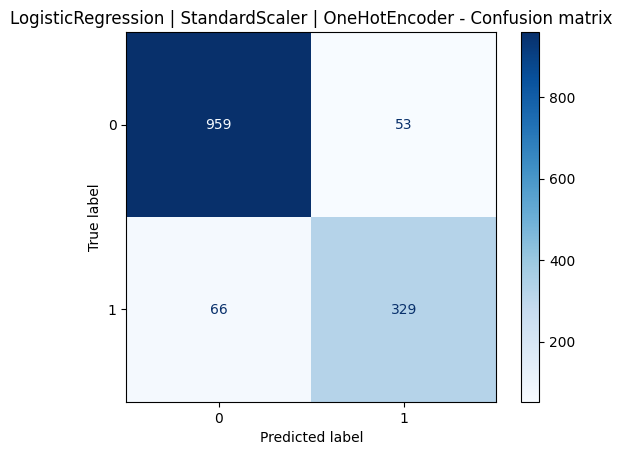


LogisticRegression | MinMaxScaler | OneHotEncoder | -> Confusion matrix


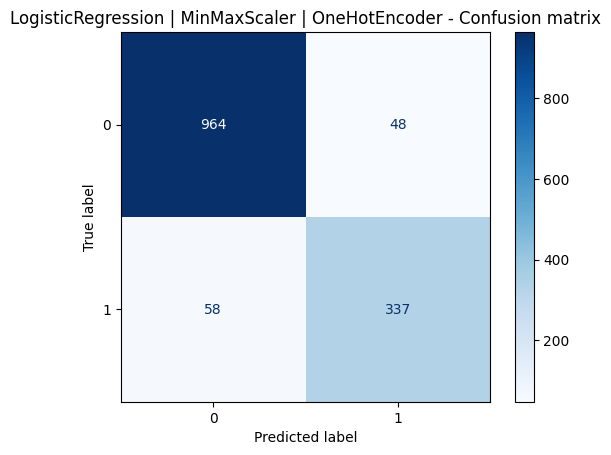


KNeighborsClassifier | StandardScaler | OneHotEncoder | -> Confusion matrix


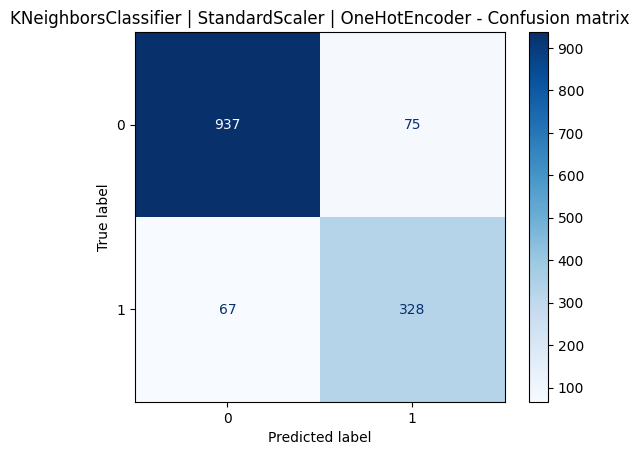


KNeighborsClassifier | MinMaxScaler | OneHotEncoder | -> Confusion matrix


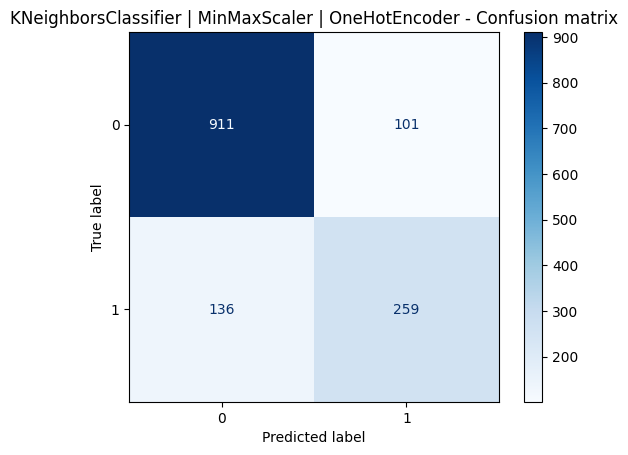


SVC | StandardScaler | OneHotEncoder | -> Confusion matrix


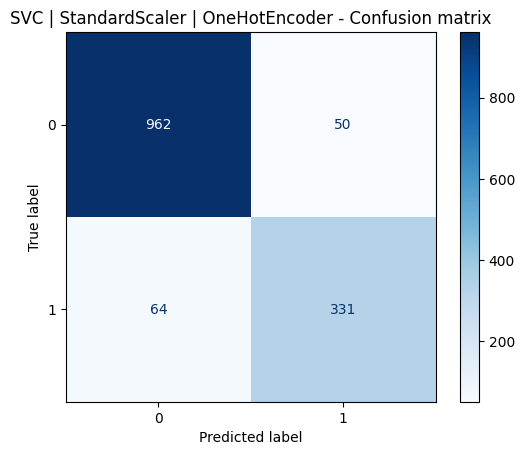


SVC | MinMaxScaler | OneHotEncoder | -> Confusion matrix


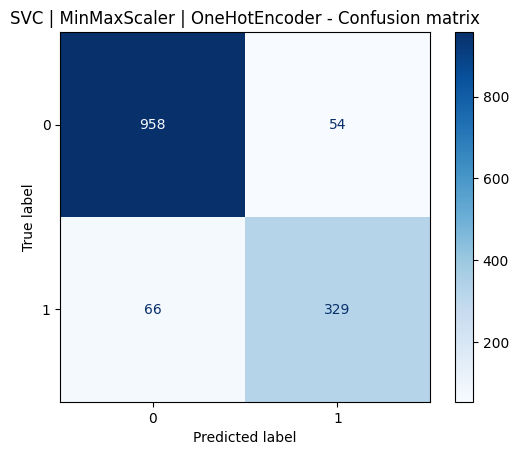


GaussianNB | StandardScaler | OneHotEncoder | -> Confusion matrix


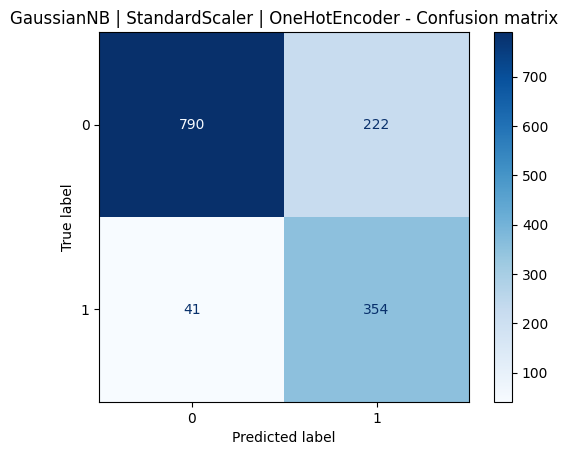


GaussianNB | MinMaxScaler | OneHotEncoder | -> Confusion matrix


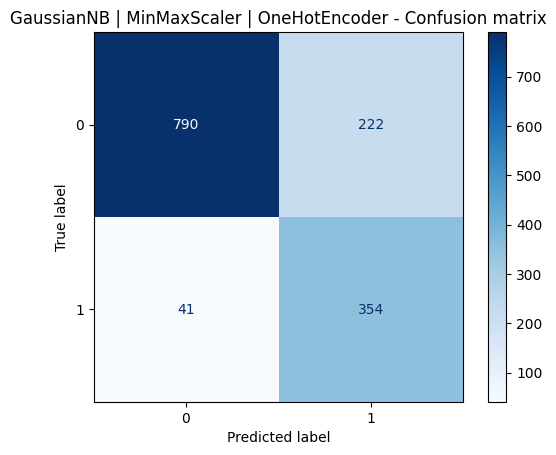


DecisionTreeClassifier | StandardScaler | OneHotEncoder | -> Confusion matrix


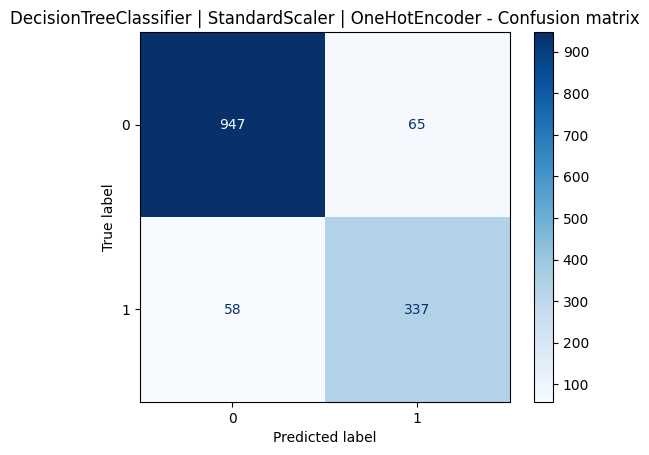


DecisionTreeClassifier | MinMaxScaler | OneHotEncoder | -> Confusion matrix


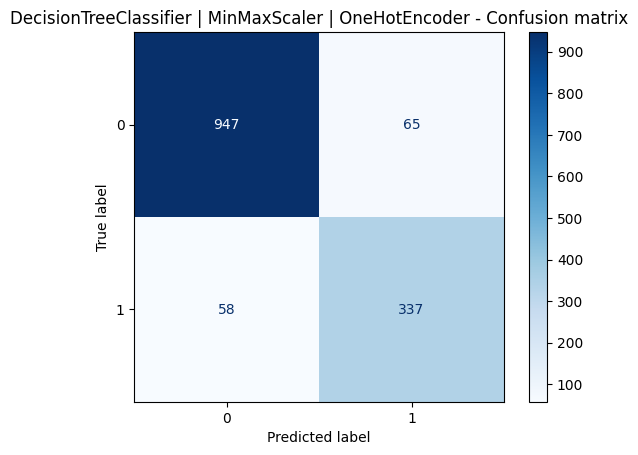


RandomForestClassifier | StandardScaler | OneHotEncoder | -> Confusion matrix


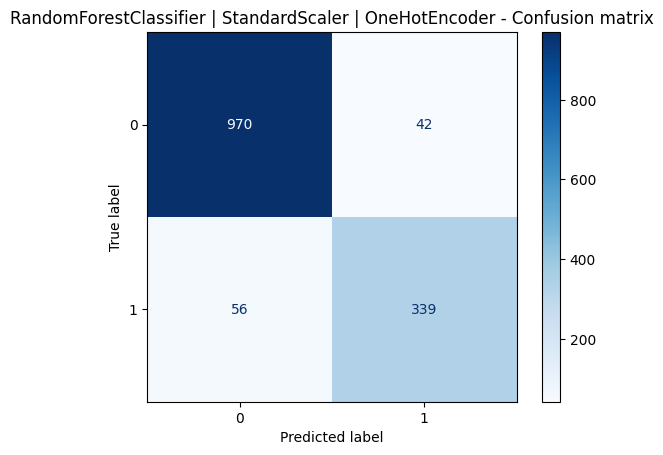


RandomForestClassifier | MinMaxScaler | OneHotEncoder | -> Confusion matrix


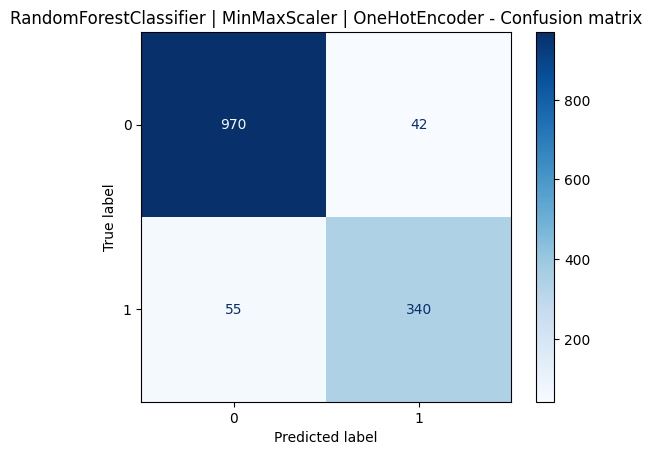


XGBClassifier | StandardScaler | OneHotEncoder | -> Confusion matrix


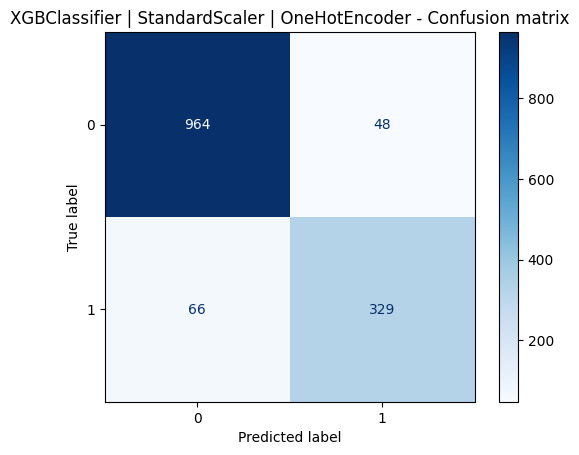


XGBClassifier | MinMaxScaler | OneHotEncoder | -> Confusion matrix


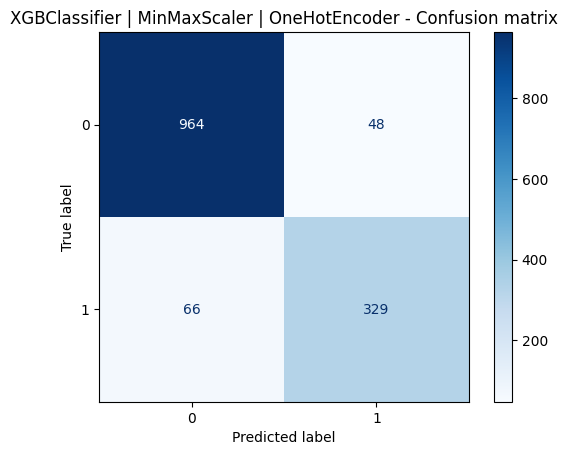

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

results = []
preds = []

for clf in classifiers:
    for num_tr in num_transformers:
        for cat_tr in cat_transformers:
            
            preprocessor = ColumnTransformer([
                ('num', num_tr, numerical_features),
                ('cat', cat_tr, categorical_features)
            ], remainder='drop')

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', clf)
            ])
            
            cv_res = cross_validate(
                pipeline, X_train, y_train,
                cv=cv, scoring=scorers, n_jobs=-1, return_estimator=False
            )
            
            start = time.time()
            pipeline.fit(X_train, y_train)
            end = time.time()

            y_pred = pipeline.predict(X_test)
            
            model_name = f"{clf.__class__.__name__} | {num_tr.__class__.__name__} | {cat_tr.__class__.__name__}"
            preds.append((model_name, y_pred))
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc_auc = roc_auc_score(y_test, y_pred)

            results.append({
                'model'            : clf.__class__.__name__,
                'num_transformer'  : num_tr.__class__.__name__,
                'cat_transformer'  : cat_tr.__class__.__name__,
                # CV (średnie)
                'cv_accuracy_mean' : cv_res['test_accuracy'].mean(),
                'cv_precision_mean': cv_res['test_precision'].mean(),
                'cv_recall_mean'   : cv_res['test_recall'].mean(),
                'cv_f1_mean'       : cv_res['test_f1'].mean(),
                'cv_auc_mean'      : cv_res['test_roc_auc'].mean(),
                # TEST
                'test_accuracy'    : acc,
                'test_precision'   : precision,
                'test_recall'      : recall,
                'test_f1'          : f1,
                'test_auc'         : roc_auc,
                'train_time_s'     : round(end - start, 2),
            })

pd.set_option('display.float_format', lambda x: '%.2f' % x)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='test_accuracy', ascending=False))

labels = np.sort(np.unique(y_test))  
for name, y_hat in preds:
    print(f'\n{name} | -> Confusion matrix')
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_hat, labels=labels,
        values_format='d',
        cmap='Blues',
    )
    plt.title(f'{name} - Confusion matrix')
    plt.show()
